In [74]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import models 
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor, Resize
import torch.nn.functional as F

import numpy as np
import pandas as pd
import time
import serial
print('serial ' + serial.__version__)

serial 3.5


In [102]:
import json

In [76]:
import matplotlib.pyplot as plt

In [103]:
PORT = 'COM4'
BaudRate = 9600
ARD = serial.Serial(PORT,BaudRate)

### 함수 정의

In [104]:
# 아두이노 시리얼 값을 한 줄 읽어와 ch1, ch2값을 리스트로 반환
def Decode():
    if ARD.readable():
        LINE = ARD.readline()
        input_string = LINE.decode(encoding='UTF-8')
        input_string = str(input_string)

        try:
            # 문자열을 공백을 기준으로 나눠서 리스트로 만듦
            # 숫자는 소수점 3번째 자리까지 표시
            number_list = [round(float(num), 3) for num in input_string.split(',')]

            # 아두이노가 ch1, ch2 중에 값 하나 빼먹는 경우 있는 것 같아서 추가함
            if len(number_list) == 2:
                pass
            else:
                number_list = [1.686, 1.686]

        except ValueError as e:
            # 오류가 발생하면 기본값으로 1.686을 사용하여 리스트를 생성
            # print(f"Error: {e}")
            number_list = [1.686, 1.686]

        return number_list
        
    else : 
        print("읽기 실패 from _Ardread_")
        return None

### data generation 실행 코드

In [105]:
# DataFrame 초기화
columns = ['Ch1', 'Ch2']
signal_df = pd.DataFrame(columns=columns)
df_length = len(signal_df)

# 변수 초기화
ignore_data = True
capturing_segment = False
print_flag = True

# noise의 max, min 값 갱신위해 설정
max_value = float('-inf')
min_value = float('inf')

# 처음 100개의 행 무시하기 위한 flag
first_count = 0
# 이후 1000개의 행 동안 noise 값 갱신하기 위한 flag
second_count = 0
# noise boundary 내의 값 연속해서 몇번 들어오는지 check하기 위한 flag
continuous_count = 0  

In [106]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        # 첫 번째 합성곱 레이어
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)

        # 두 번째 합성곱 레이어
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)

        # 스킵 연결을 위한 합성곱 레이어 (stride가 1보다 클 때만 사용)
        self.skip_layer = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)

    def forward(self, x):
        # 첫 번째 합성곱 레이어
        out = F.relu(self.bn1(self.conv1(x)))

        # 두 번째 합성곱 레이어
        out = self.bn2(self.conv2(out))

        # 스킵 연결
        skip_out = self.skip_layer(x) if self.skip_layer is not None else x
        out += skip_out

        # ReLU 활성화 함수
        out = F.relu(out)
        return out
class ResNet1D(nn.Module):
    def __init__(self, input_channels, num_classes=3):
        super(ResNet1D, self).__init__()

        # 초기 합성곱 레이어
        self.initial_conv = nn.Conv1d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.initial_bn = nn.BatchNorm1d(64)
        self.initial_relu = nn.ReLU(inplace=True)

        # Residual 블록
        self.layer1 = self.make_layer(64, 64, stride=2)
        self.layer2 = self.make_layer(64, 128, stride=2)

        # Global Average Pooling
        self.global_avg_pooling = nn.AdaptiveAvgPool1d(1)

        # 완전 연결 레이어
        self.fc = nn.Linear(128, num_classes)

    def make_layer(self, in_channels, out_channels, stride=1):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        layers.append(ResidualBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        # 초기 합성곱 레이어
        x = self.initial_relu(self.initial_bn(self.initial_conv(x)))

        # Residual 블록
        x = self.layer1(x)
        x = self.layer2(x)

        # Global Average Pooling
        x = self.global_avg_pooling(x)

        # 완전 연결 레이어
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [107]:
# ch2 값 기준으로 읽어올 거임

print("초기값 setting 중...")

# 반복해서 arduino에서 데이터값 읽어옴
while (True):
    number_list = Decode()

    # arduino에서 받아오는 처음 5000행의 데이터를 무시
    if ignore_data:
        if first_count < 5000:
            first_count += 1
            continue
        else:
            ignore_data = False
            print("noise 값 갱신중...")

    # 5000행의 데이터 이후 처리
    else:
        if number_list is not None: 

            if second_count < 1000:
                # 1000행 동안 noise의 최댓값과 최솟값 갱신
                max_value = max(max_value, number_list[1])
                min_value = min(min_value, number_list[1])
                second_count += 1
                continue
            else:
                if print_flag:
                    print("동작준비 완료!", "noise boundary: ",min_value, " ~ ",max_value)
                    print_flag = False

                # noise 값 갱신된 이후 min보다 작거나 max 보다 큰 값이 들어오면 접촉이 이루어졌다고 간주하고 데이터프레임에 저장
                if number_list[1] < (min_value-0.05) or number_list[1] > (max_value+0.05):
                    capturing_segment = True

                # capturing_segment가 true면 계속 저장
                if capturing_segment:

                    # DataFrame에 행 추가
                    signal_df.loc[len(signal_df)] = number_list
                    print("접촉발생: ", number_list, len(signal_df))

                    # noise boundary 내의 값이 들어오면 count continuous_count로 몇번 연속 들어왔는지 check
                    if number_list[1] > (min_value-0.05) and number_list[1] < (max_value+0.05):
                        continuous_count += 1
                    else:
                        continuous_count = 0
                        
                    # 1000개 연속으로 noise boundary 내의 값이 들어오면 저장 종료
                    if continuous_count >= 1000:
                        print(f"Contact ended at row {len(signal_df)}")
                        capturing_segment = False  # Set flag to stop capturing

                        ####################################################################################################################### AI 적용 부분
                        # signal_df 내의 ch2 값들 signal_list로 변환
                        signal_list = signal_df['Ch2'].tolist()

                        # signal_list를 numpy 배열로 변환
                        signal_np = np.array(signal_list[:200], dtype=np.float32)

                        # numpy 배열을 전치하여 형태를 맞추고 텐서로 변환
                        signal_tensor = torch.tensor(signal_np.transpose(), dtype=torch.float)
                        # print("just_tensor_size: ", signal_tensor.size())

                        # 텐서의 크기를 조정하여 원하는 크기로 보간
                        # 여기서는 크기를 (1024,)로 조정하는 것으로 가정합니다.
                        signal_tensor = F.interpolate(signal_tensor.unsqueeze(0).unsqueeze(0), size=(1024)).squeeze(0)
                        # print("interpol_tensor_size: ", signal_tensor.size())

                        # model 불러오기
                        model = torch.load("best_one.pth", map_location=torch.device('cpu'))

                        # 추론을 위해 모델에 텐서를 입력하고 결과를 얻습니다.
                        
                        with torch.no_grad():
                            output = model(signal_tensor.unsqueeze(0))
                        
                        # print("output_only: ", output)
                        class_result = torch.argmax(output,dim=1)

                        # plt.plot(signal_list)
                        # plt.show()
                        print("classificaltion result: ", class_result.item())

                        # streamlit과 공유할 변수에 classification 결과값 append. streamlit에서는 FIFO 형태로 가져다 씀. global_class_result[0] 

                        class_data = {
                            "class_result" : class_result.item()
                        }
                        with open('class_dict.json','w') as f:
                            json.dump(class_data, f)
                        
                        # 0,1,2 각각 톡, 쓰담, 잡기
                        ####################################################################################################################### 

                        # dataframe 초기화
                        columns = ['Ch1', 'Ch2']
                        signal_df = pd.DataFrame(columns=columns)

                        # 초기값 무시 및 noise 갱신과정은 반복하지 않음

                        

초기값 setting 중...
noise 값 갱신중...
동작준비 완료! noise boundary:  1.681  ~  1.691
접촉발생:  [1.237, 1.926] 1
접촉발생:  [0.435, 2.16] 2
접촉발생:  [2.033, 2.639] 3
접촉발생:  [1.716, 2.82] 4
접촉발생:  [1.623, 2.796] 5
접촉발생:  [1.955, 2.742] 6
접촉발생:  [1.623, 2.722] 7
접촉발생:  [1.579, 2.615] 8
접촉발생:  [1.657, 2.527] 9
접촉발생:  [1.691, 2.434] 10
접촉발생:  [1.725, 2.346] 11
접촉발생:  [1.681, 2.268] 12
접촉발생:  [1.681, 2.199] 13
접촉발생:  [1.672, 2.146] 14
접촉발생:  [1.676, 2.097] 15
접촉발생:  [1.706, 2.048] 16
접촉발생:  [1.676, 2.004] 17
접촉발생:  [1.701, 1.965] 18
접촉발생:  [1.686, 1.935] 19
접촉발생:  [1.681, 1.906] 20
접촉발생:  [1.701, 1.877] 21
접촉발생:  [1.686, 1.857] 22
접촉발생:  [1.686, 1.833] 23
접촉발생:  [1.686, 1.818] 24
접촉발생:  [1.681, 1.804] 25
접촉발생:  [1.686, 1.789] 26
접촉발생:  [1.691, 1.779] 27
접촉발생:  [1.681, 1.764] 28
접촉발생:  [1.691, 1.76] 29
접촉발생:  [1.681, 1.75] 30
접촉발생:  [1.686, 1.745] 31
접촉발생:  [1.696, 1.735] 32
접촉발생:  [1.681, 1.725] 33
접촉발생:  [1.691, 1.72] 34
접촉발생:  [1.681, 1.72] 35
접촉발생:  [1.691, 1.716] 36
접촉발생:  [1.696, 1.711] 37
접촉발생:  [1.676, 1

KeyboardInterrupt: 

In [108]:
with open('class_dict.json', 'r') as f:
    data = json.load(f)

print("JSON 파일에서 읽은 데이터: ", data['class_result'])

JSON 파일에서 읽은 데이터:  0


### Test set 으로 보기

In [ ]:
# ch2 값 기준으로 읽어올 거임

print("초기값 setting 중...")

# 반복해서 arduino에서 데이터값 읽어옴
while (True):
    number_list = Decode()

    # arduino에서 받아오는 처음 5000행의 데이터를 무시
    if ignore_data:
        if first_count < 5000:
            first_count += 1
            continue
        else:
            ignore_data = False
            print("noise 값 갱신중...")

    # 5000행의 데이터 이후 처리
    else:
        if number_list is not None: 

            if second_count < 1000:
                # 1000행 동안 noise의 최댓값과 최솟값 갱신
                max_value = max(max_value, number_list[1])
                min_value = min(min_value, number_list[1])
                second_count += 1
                continue
            else:
                if print_flag:
                    print("동작준비 완료!", "noise boundary: ",min_value, " ~ ",max_value)
                    print_flag = False

                # noise 값 갱신된 이후 min보다 작거나 max 보다 큰 값이 들어오면 접촉이 이루어졌다고 간주하고 데이터프레임에 저장
                if number_list[1] < (min_value-0.05) or number_list[1] > (max_value+0.05):
                    capturing_segment = True

                # capturing_segment가 true면 계속 저장
                if capturing_segment:

                    # DataFrame에 행 추가
                    signal_df.loc[len(signal_df)] = number_list
                    print("접촉발생: ", number_list, len(signal_df))

                    # noise boundary 내의 값이 들어오면 count continuous_count로 몇번 연속 들어왔는지 check
                    if number_list[1] > (min_value-0.05) and number_list[1] < (max_value+0.05):
                        continuous_count += 1
                    else:
                        continuous_count = 0
                        
                    # 1000개 연속으로 noise boundary 내의 값이 들어오면 저장 종료
                    if continuous_count >= 1000:
                        print(f"Contact ended at row {len(signal_df)}")
                        capturing_segment = False  # Set flag to stop capturing

                        ####################################################################################################################### AI 적용 부분
                        # signal_df 내의 ch2 값들 signal_list로 변환
                        signal_list = signal_df['Ch2'].tolist()

                        # signal_list를 numpy 배열로 변환
                        signal_np = np.array(signal_list[:200], dtype=np.float32)

                        # numpy 배열을 전치하여 형태를 맞추고 텐서로 변환
                        signal_tensor = torch.tensor(signal_np.transpose(), dtype=torch.float)
                        # print("just_tensor_size: ", signal_tensor.size())

                        # 텐서의 크기를 조정하여 원하는 크기로 보간
                        # 여기서는 크기를 (1024,)로 조정하는 것으로 가정합니다.
                        signal_tensor = F.interpolate(signal_tensor.unsqueeze(0).unsqueeze(0), size=(1024)).squeeze(0)
                        # print("interpol_tensor_size: ", signal_tensor.size())

                        # model 불러오기
                        model = torch.load("classification_model.pth", map_location=torch.device('cpu'))

                        # 추론을 위해 모델에 텐서를 입력하고 결과를 얻습니다.
                        with torch.no_grad():
                            output = model(signal_tensor.unsqueeze(0))
                        
                        print("output_only: ", output)
                        # class_result = torch.argmax(output,dim=1)

                        plt.plot(signal_list)
                        plt.show()
                        #print("classificaltion result: ", class_result.item())

                        
                        # 0,1,2 각각 톡, 쓰담, 잡기
                        ####################################################################################################################### 

                        # dataframe 초기화
                        columns = ['Ch1', 'Ch2']
                        signal_df = pd.DataFrame(columns=columns)

                        # 초기값 무시 및 noise 갱신과정은 반복하지 않음

                        

In [47]:
signal_test_df = pd.read_csv('./test/3/3_5.csv', header=0)

In [48]:
signal_test_df

,Ch1,Ch2
0,1.764,1.774
1,1.628,1.779
2,1.813,1.779
3,1.652,1.789
4,1.647,1.789
...,...,...
1253,1.735,1.706
1254,1.696,1.711
1255,1.676,1.706
1256,1.735,1.711


output_only:  tensor([[-1.8602,  0.4454, -0.0704]])


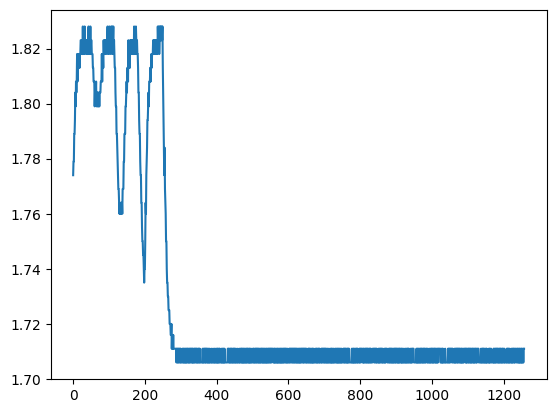

In [50]:

                        # signal_df 내의 ch2 값들 signal_list로 변환
                        signal_list = signal_test_df['Ch2'].tolist()

                        # signal_list를 numpy 배열로 변환
                        signal_np = np.array(signal_list[:200], dtype=np.float32)

                        # numpy 배열을 전치하여 형태를 맞추고 텐서로 변환
                        signal_tensor = torch.tensor(signal_np.transpose(), dtype=torch.float)
                        # print("just_tensor_size: ", signal_tensor.size())

                        # 텐서의 크기를 조정하여 원하는 크기로 보간
                        # 여기서는 크기를 (1024,)로 조정하는 것으로 가정합니다.
                        signal_tensor = F.interpolate(signal_tensor.unsqueeze(0).unsqueeze(0), size=(1024)).squeeze(0)
                        # print("interpol_tensor_size: ", signal_tensor.size())

                        # model 불러오기
                        model = torch.load("classification_model.pth", map_location=torch.device('cpu'))

                        # 추론을 위해 모델에 텐서를 입력하고 결과를 얻습니다.
                        with torch.no_grad():
                            output = model(signal_tensor.unsqueeze(0))
                        
                        print("output_only: ", output)
                        # class_result = torch.argmax(output,dim=1)

                        plt.plot(signal_list)
                        plt.show()
                        #print("classificaltion result: ", class_result.item())